In [154]:
import cv2
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from ipywidgets import interactive, fixed, widgets
from IPython.display import display
%ls img

img_path = './img/Img1.jpg'

ImagenProcesada.jpg  Img12.jpg  Img1.jpg  Img5.jpg  Prueba.jpg
Img11.jpg            Img15.jpg  Img3.jpg  Img6.jpg


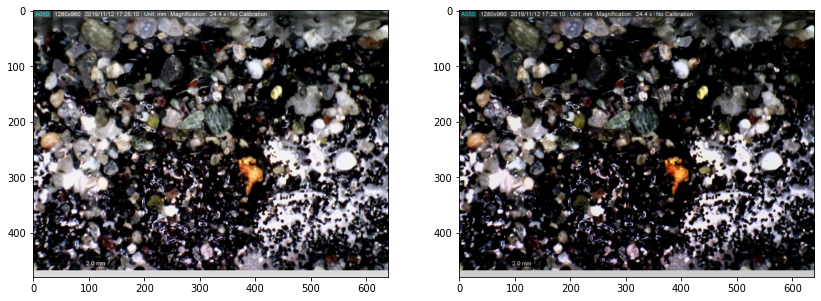

In [157]:
img = cv2.imread(img_path)
img = cv2.resize(img, (640, 480))
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
img = (255 * (img / 255) ** 1.5).astype(np.uint8)
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [ ]:
img = cv2.imread(img_path)
#img = cv2.resize(img, (640, 480))
#img = cv2.blur(img, ksize=(10, 10))
img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

hsv_scale = np.zeros((180, 256, 3), dtype=np.uint8)
hsv_scale[:, :, 0] = np.linspace(0, 179, 180).reshape(-1, 1)
hsv_scale[:, :, 2] = 255

def transform_img_hsv(img, low_h, high_h, low_s, low_v):
    trigger_h = low_h
    thresh_h = high_h
    trigger_s = low_s
    trigger_v = low_v
    hsv_scale[:, :, 1] = np.linspace(trigger_s, 255, 256).reshape(1, -1)
    color_rng = (np.array([trigger_h, trigger_s, trigger_v]), np.array([thresh_h, 255, 255]))
    mask = cv2.inRange(img, *color_rng)
    img = cv2.bitwise_and(img, img, mask=mask)
    img[:, :, 2][img[:, :, 2] > 0] = 255
    #img[:, :, 1] = cv2.equalizeHist(img[:, :, 1])
    
    img = cv2.cvtColor(
        cv2.erode(
            cv2.cvtColor(img, cv2.COLOR_HSV2BGR),
            np.ones((5, 5))
        ),
        cv2.COLOR_BGR2HSV
    )

In [70]:
img = cv2.imread(img_path)
#img = cv2.resize(img, (640, 480))
#img = cv2.blur(img, ksize=(10, 10))
img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

hsv_scale = np.zeros((180, 256, 3), dtype=np.uint8)
hsv_scale[:, :, 0] = np.linspace(0, 179, 180).reshape(-1, 1)
hsv_scale[:, :, 2] = 255

def transform_img_hsv(img, low_h, high_h, low_s, low_v):
    trigger_h = low_h
    thresh_h = high_h
    trigger_s = low_s
    trigger_v = low_v
    hsv_scale[:, :, 1] = np.linspace(trigger_s, 255, 256).reshape(1, -1)
    color_rng = (np.array([trigger_h, trigger_s, trigger_v]), np.array([thresh_h, 255, 255]))
    mask = cv2.inRange(img, *color_rng)
    img = cv2.bitwise_and(img, img, mask=mask)
    img[:, :, 2][img[:, :, 2] > 0] = 255
    #img[:, :, 1] = cv2.equalizeHist(img[:, :, 1])
    
#    img = cv2.cvtColor(
#        cv2.erode(
#            cv2.cvtColor(img, cv2.COLOR_HSV2BGR),
#            np.ones((5, 5))
#        ),
#        cv2.COLOR_BGR2HSV
#    )
    
    hue = img[:, :, 0][img[:, :, 2] == 255]
    sat = img[:, :, 1][img[:, :, 2] == 255]
    low_line = np.arange(hsv_scale.shape[1]), trigger_h * np.ones(hsv_scale.shape[1])
    high_line = np.arange(hsv_scale.shape[1]), thresh_h * np.ones(hsv_scale.shape[1])
    plt.figure()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_HSV2RGB))
    plt.figure()
    plt.imshow(cv2.cvtColor(hsv_scale, cv2.COLOR_HSV2RGB))
    plt.plot(*low_line, 'black')
    plt.plot(*high_line, 'black')
    plt.plot(sat, hue, 'o', markersize=8)


display(interactive(
    transform_img_hsv,
    img=fixed(img),
    low_h=widgets.IntSlider(min=0, max=179, value=12),
    high_h=widgets.IntSlider(min=0, max=179, value=20),
    low_s=widgets.IntSlider(min=0, max=255, value=120),
    low_v=widgets.IntSlider(min=0, max=255, value=130),
))

interactive(children=(IntSlider(value=12, description='low_h', max=179), IntSlider(value=20, description='high…

In [156]:
img_org = cv2.imread(img_path)
img_org = cv2.resize(img_org, (640, 480))
#img = cv2.blur(img, ksize=(20, 20))
img_org = cv2.cvtColor(img_org, cv2.COLOR_BGR2HLS)


hls_scale = np.zeros((180, 256, 3), dtype=np.uint8)
hls_scale[:, :, 0] = np.linspace(0, 179, 180).reshape(-1, 1)
hls_scale[:, :, 1] = 127

def transform_img_hls(img, low_h, high_h, low_s, low_l, high_l, gamma):
    hls_scale[:, :, 2] = np.linspace(low_s, 255, 256).reshape(1, -1)
    img = img.copy()
    img[:, :, 1] = (255 * (img[:, :, 1] / 255) ** gamma).astype(np.uint8)
    color_rng = (np.array([low_h, low_l, low_s]), np.array([high_h, high_l, 255]))
    mask = cv2.inRange(img, *color_rng)
    img = cv2.bitwise_and(img, img, mask=mask)
    
    img = cv2.cvtColor(
        cv2.dilate(
            cv2.cvtColor(img, cv2.COLOR_HLS2BGR),
            np.ones((5, 5))
        ),
        cv2.COLOR_BGR2HLS
    )
    
    img = cv2.cvtColor(
        cv2.erode(
            cv2.cvtColor(img, cv2.COLOR_HLS2BGR),
            np.ones((8, 8))
        ),
        cv2.COLOR_BGR2HLS
    )
    
    img = cv2.cvtColor(
        cv2.dilate(
            cv2.cvtColor(img, cv2.COLOR_HLS2BGR),
            np.ones((5, 5))
        ),
        cv2.COLOR_BGR2HLS
    )
    
    hue = img[:, :, 0][img[:, :, 1] != 0]
    sat = img[:, :, 2][img[:, :, 1] != 0]
    low_line = np.arange(hls_scale.shape[1]), low_h * np.ones(hls_scale.shape[1])
    high_line = np.arange(hls_scale.shape[1]), high_h * np.ones(hls_scale.shape[1])
    plt.figure()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_HLS2RGB))
    plt.figure()
    plt.imshow(cv2.cvtColor(hls_scale, cv2.COLOR_HLS2RGB))
    plt.plot(*low_line, 'black', linewidth=1.0)
    plt.plot(*high_line, 'black', linewidth=1.0)
    plt.plot(sat, hue, 'o', markersize=5)


display(interactive(
    transform_img_hls,
    img=fixed(img_org),
    low_h=widgets.IntSlider(min=0, max=179, value=12),
    high_h=widgets.IntSlider(min=0, max=179, value=22),
    low_s=widgets.IntSlider(min=0, max=255, value=140),
    low_l=widgets.IntSlider(min=0, max=255, value=50),
    high_l=widgets.IntSlider(min=0, max=255, value=200),
    gamma=widgets.FloatLogSlider(min=-4, max=1, value=2.0, step=0.05),
))

interactive(children=(IntSlider(value=12, description='low_h', max=179), IntSlider(value=22, description='high…

In [71]:
arr = np.array([[1, 1], [2, 2]])

In [73]:
arr[arr == 2] = 3

In [77]:
arr[arr == 3]

array([3, 3])